# Can application layer DoS attacks be detected using machine learning

### Project Aims to address the following
1. Which features are more important?
    * Decision tree?
2. Are any features redundant?
    * Correlation between features
3. Best model?
    * SVM on all data?
4. How does adding more data effect things
    * Kaizen results
5. Feature space transform
    * PCA
    * Autoenc?
6. Can Algorithm learn features?
    * Representation learning


In [15]:
import pandas as pd
data_path = '../csv/expanded_dataset_v1.csv'
data = pd.read_csv(data_path)

X = data.drop(['Class'], axis=1)
Y = data['Class']

### 1. Feature Importance

In [2]:
from sklearn import tree
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

tree_classifier = tree.DecisionTreeClassifier(max_depth=5)
predicted = cross_val_predict(tree_classifier, X, Y, cv=10)

accuracy = accuracy_score(Y, predicted) 

print("Tree accuracy {}".format(accuracy))


Tree accuracy 0.7964774951076321


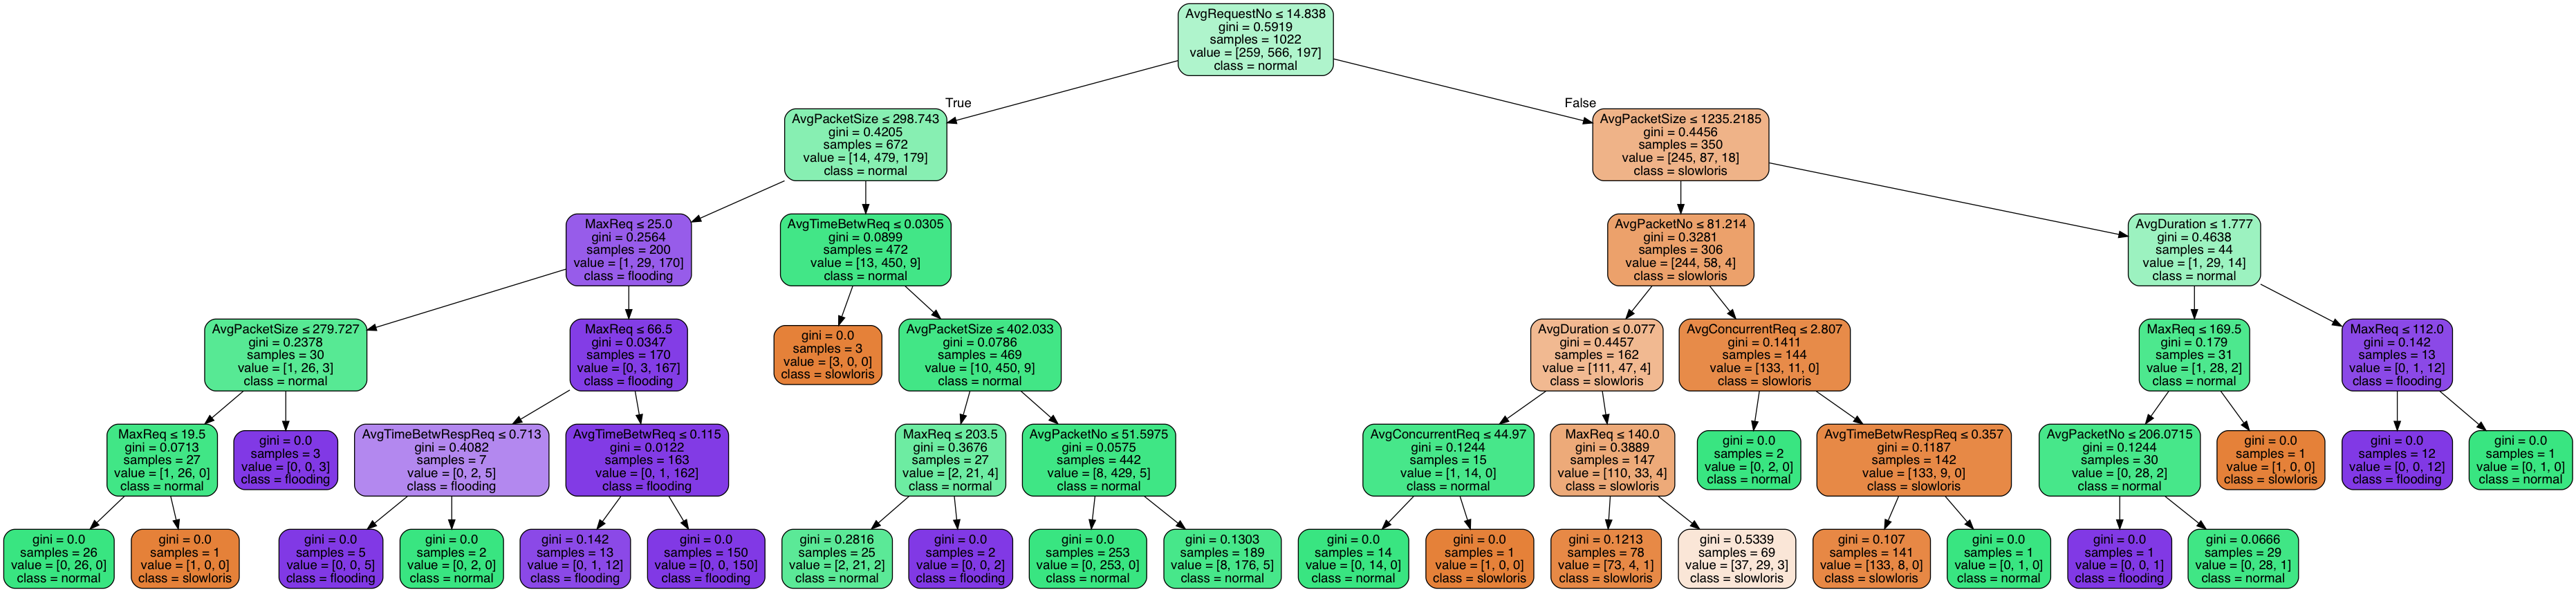

In [10]:
import pydotplus
from IPython.display import Image

tree_classifier = tree.DecisionTreeClassifier(max_depth=5)
tree_classifier.fit(X, Y)
dot_data = tree.export_graphviz(tree_classifier, out_file=None, 
                         feature_names=list(X),  
                         class_names=Y.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

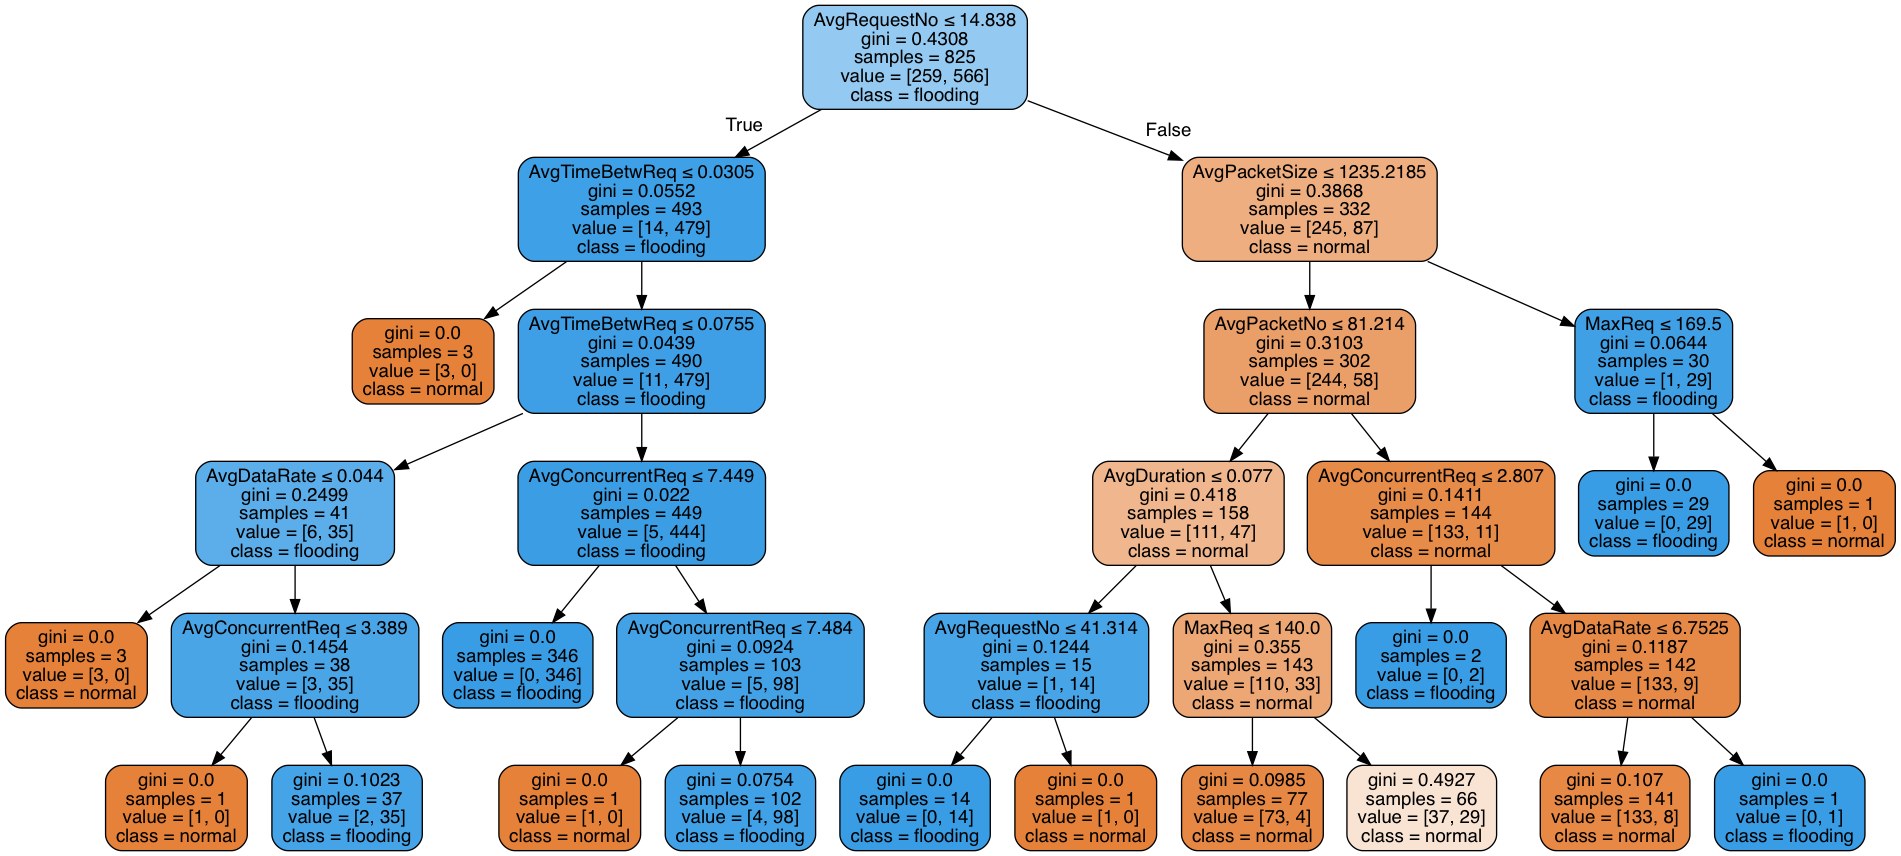

In [12]:
import pydotplus
from IPython.display import Image
normal_flood_data = data[data.Class != 'slowloris']

X_flood = normal_flood_data.drop(['Class'], axis=1)
Y_flood = normal_flood_data['Class']

tree_classifier = tree.DecisionTreeClassifier(max_depth=5)
tree_classifier.fit(X_flood, Y_flood)
dot_data = tree.export_graphviz(tree_classifier, out_file=None, 
                         feature_names=list(X_flood),  
                         class_names=Y_flood.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

Class
flooding     Axes(0.125,0.125;0.775x0.755)
normal       Axes(0.125,0.125;0.775x0.755)
slowloris    Axes(0.125,0.125;0.775x0.755)
Name: AvgRequestNo, dtype: object

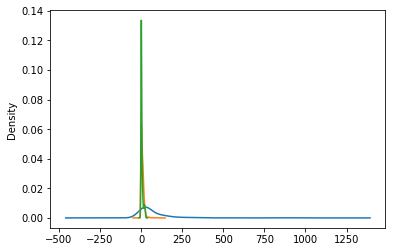

In [23]:
data.groupby('Class').AvgRequestNo.plot(kind='kde')

### 2. Feature Redundance

In [7]:
%matplotlib inline 
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
norm = pd.DataFrame(scale(X), columns=list(X))
scaled = pd.DataFrame(minmax_scale(norm, feature_range=(-1, 1)), columns=list(X))
scaled.mean()

csv = scaled
csv['Class'] = Y 
csv.to_csv('../csv/mean_scaled_full.csv', index=False)

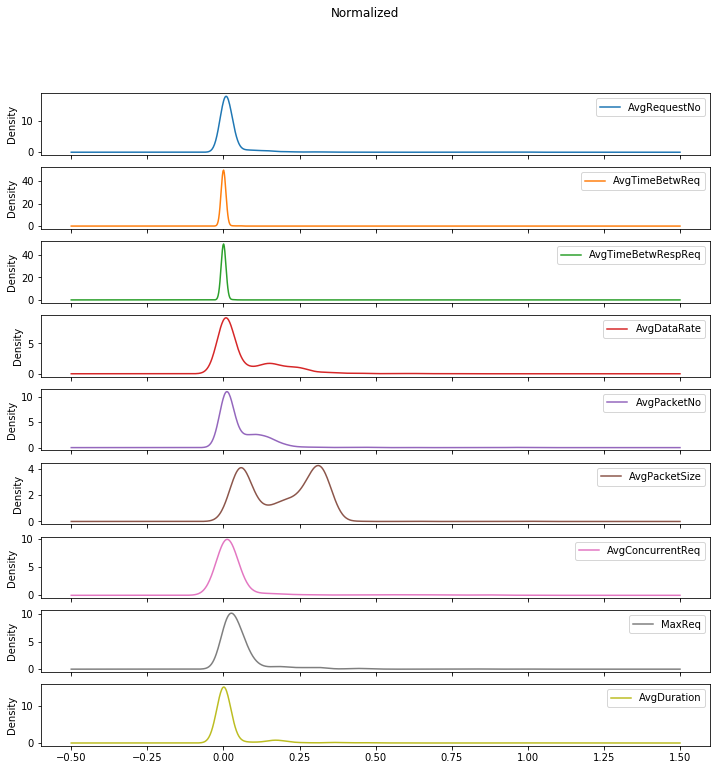

In [127]:
p = scaled.plot(kind='density', subplots=True, figsize=(12,12), title="Normalized")

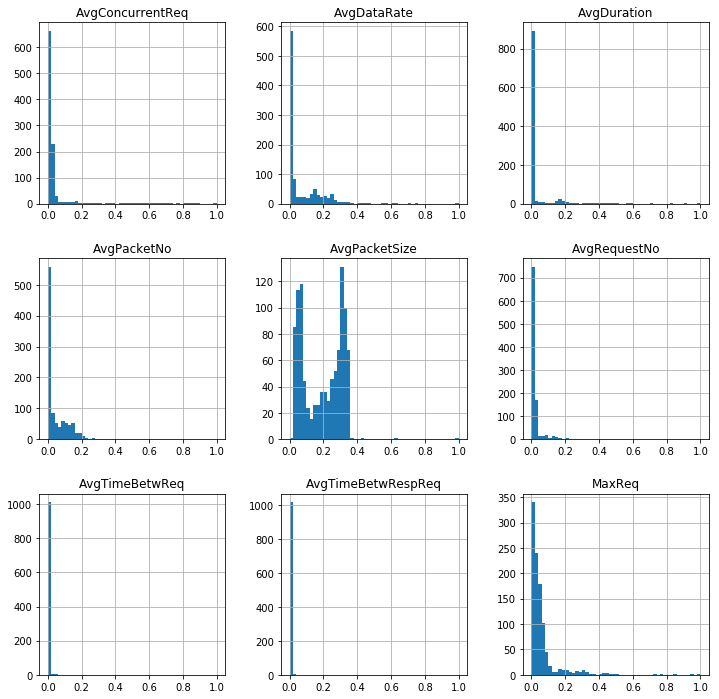

In [128]:
p = scaled.hist(figsize=(12,12), bins=50)

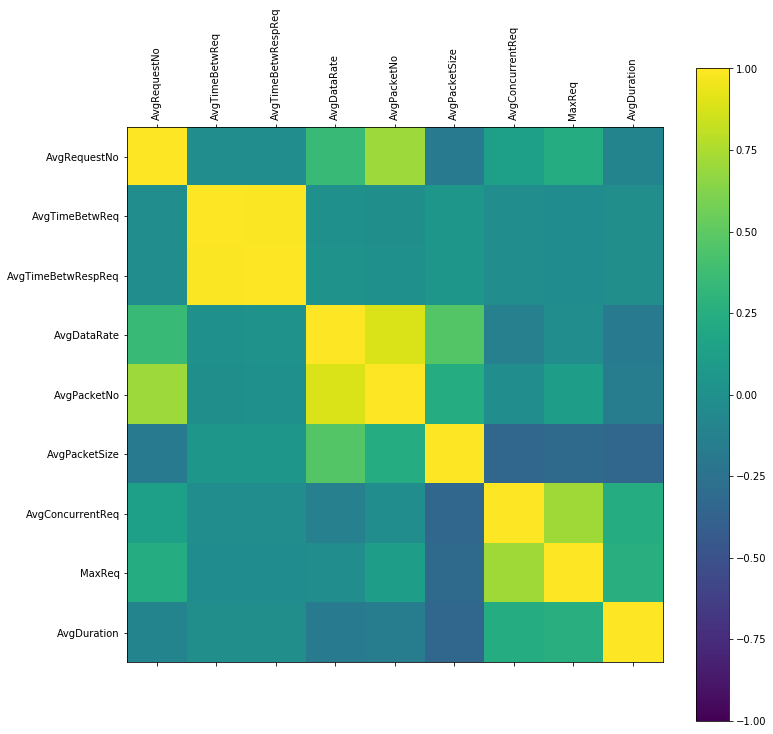

In [53]:
import matplotlib.pyplot as plt
import numpy
correlations = scaled.corr()
# plot correlation matrix
names = list(X)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation=90)
plt.show()

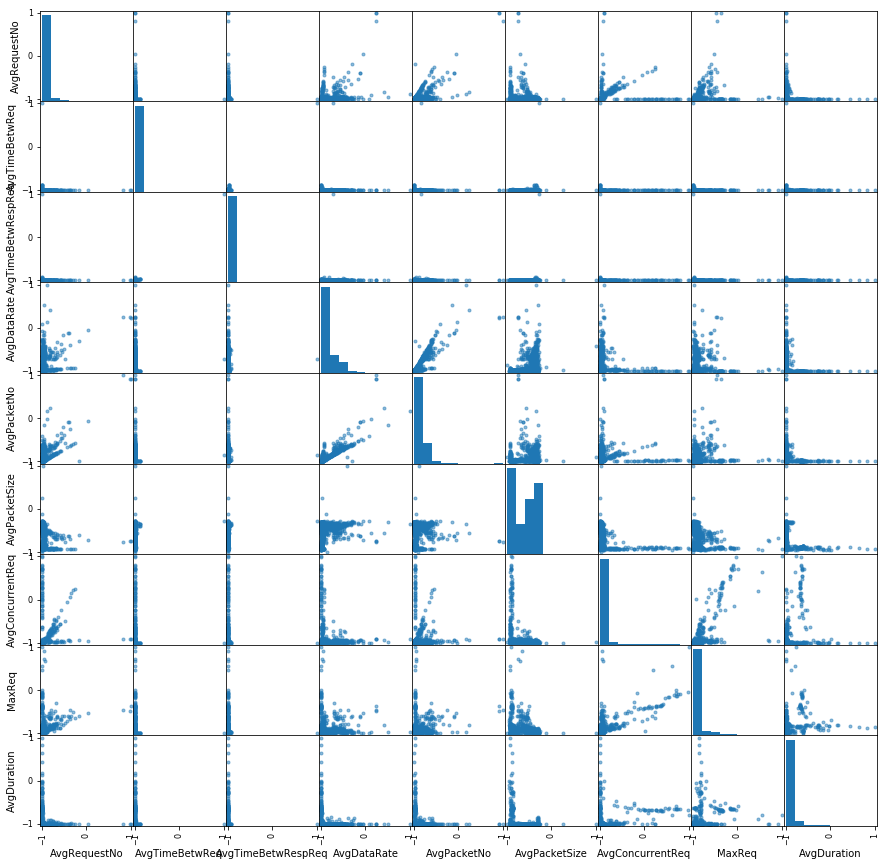

In [54]:
import matplotlib.pyplot as plt
import pandas
from pandas.tools.plotting import scatter_matrix
scatter_matrix(scaled, figsize=(15,15))
plt.show()

### 3. Best Model

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = [{'n_estimators':[10, 20, 30, 40, 50], 'random_state':[777] }]

search = GridSearchCV(rf, parameters, cv=10)
search.fit(scaled, Y)
accuracy = search.best_score_

print(accuracy)

0.860078277886


In [56]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

ab = AdaBoostClassifier()
parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100] }]

search = GridSearchCV(ab, parameters, cv=10)
search.fit(scaled, Y)
accuracy = search.best_score_

print(accuracy)

0.782778864971


In [60]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear')
parameters = [{
    'C':[x ** y for x, y in zip([2] * 31, range(-15, 16, 1))], 
    'gamma': [x ** y for x, y in zip([2] * 31, range(-15, 16, 1))],
    'kernel': ['rbf'],
    'decision_function_shape': ['ovr']
}]

search = GridSearchCV(svm, parameters, cv=10, n_jobs=-1, verbose=1)
search.fit(scaled, Y)
accuracy = search.best_score_

print(accuracy)

Fitting 10 folds for each of 961 candidates, totalling 9610 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 7088 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9464 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 9610 out of 9610 | elapsed:  1.7min finished


0.824853228963
